In [1]:
'''
TORCWA Example0
Fresnel equation

'''
# Import
import numpy as np
import torch
from matplotlib import pyplot as plt

import torcwa

# Hardware
# If GPU support TF32 tensor core, the matmul operation is faster than FP32 but with less precision.
# If you need accurate operation, you have to disable the flag below.
torch.backends.cuda.matmul.allow_tf32 = False
sim_dtype = torch.complex64
geo_dtype = torch.float32
device = torch.device('cuda')

# Simulation environment
# light
lamb0 = 532.                # nm
azi_ang = 0.*(np.pi/180)    # radian

# material
substrate_eps = 2.**2

# geometry
L = [300., 300.]            # nm / nm
torcwa.rcwa_geo.device = device
torcwa.rcwa_geo.dtype = geo_dtype
torcwa.rcwa_geo.Lx = L[0]
torcwa.rcwa_geo.Ly = L[1]
torcwa.rcwa_geo.nx = 300
torcwa.rcwa_geo.ny = 300
torcwa.rcwa_geo.grid()
torcwa.rcwa_geo.edge_sharpness = 1000.

x_axis = torcwa.rcwa_geo.x.cpu()
y_axis = torcwa.rcwa_geo.y.cpu()

In [2]:
# Generate and perform simulation
order_N = 7
order = [order_N,order_N]
inc_ang = torch.linspace(0.,40.,40,dtype=geo_dtype,device=device)*(np.pi/180)

r_TM = []
r_TE = []
for ia_ind in range(len(inc_ang)):
    inc_ang_now = inc_ang[ia_ind]
    sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang_now,azi_ang=azi_ang)
    sim.solve_global_smatrix()
    r_TM.append(sim.S_parameters(orders=[0,0],direction='forward',port='reflection',polarization='xx',ref_order=[0,0]))
    r_TE.append(sim.S_parameters(orders=[0,0],direction='forward',port='reflection',polarization='yy',ref_order=[0,0]))

r_TM = torch.cat(r_TM)
r_TE = torch.cat(r_TE)

In [3]:
# Analytic
n1 = 2.
n2 = 1.

R_TM_an = torch.abs( (n1*torch.sqrt(1-(n1/n2*torch.sin(inc_ang.to(sim_dtype)))**2) - n2*torch.cos(inc_ang.to(sim_dtype))) \
    / (n1*torch.sqrt(1-(n1/n2*torch.sin(inc_ang.to(sim_dtype)))**2) + n2*torch.cos(inc_ang.to(sim_dtype))) )**2
R_TE_an = torch.abs( (n1*torch.cos(inc_ang.to(sim_dtype)) - n2*torch.sqrt(1-(n1/n2*torch.sin(inc_ang.to(sim_dtype)))**2)) \
    / (n1*torch.cos(inc_ang.to(sim_dtype)) + n2*torch.sqrt(1-(n1/n2*torch.sin(inc_ang.to(sim_dtype)))**2)) )**2

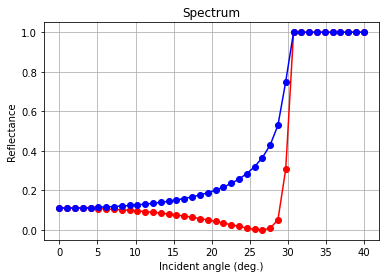

In [4]:
# View spectrum
plt.plot(180/np.pi*inc_ang.cpu(),R_TM_an.cpu(),'r')
plt.plot(180/np.pi*inc_ang.cpu(),R_TE_an.cpu(),'b')
plt.plot(180/np.pi*inc_ang.cpu(),torch.abs(r_TM).cpu()**2,'ro')
plt.plot(180/np.pi*inc_ang.cpu(),torch.abs(r_TE).cpu()**2,'bo')
plt.title('Spectrum')
plt.xlabel('Incident angle (deg.)')
plt.ylabel('Reflectance')
plt.grid()